# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression

Linear regression is used to model and predict continuous outcomes with normal random errors. There are nearly an infinite number of different types of regression models and each regression model is typically defined by the distribution of the prediction errors (called "residuals") of the type of data. Logistic regression is used to model binary outcomes whereas Poisson regression is used to predict counts. In this exercise, we'll see some examples of linear regression as well as Train-test splits.

The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [373]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,10
sns.set_style("whitegrid")
sns.set_context("poster")
import matplotlib.style as style
import matplotlib as mpl
mpl.style.use('classic')

***
# Part 1: Introduction to Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset containing predictor variables $X$ and outcome/response variable $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $\hat{Y}$, using new data $X^*$ where $Y$ is unknown.</li>
  <li> Model the <b>strength of the relationship</b> between each independent variable $X_i$ and $Y$</li>
    <ul>
      <li> Many times, only a subset of independent variables $X_i$ will have a linear relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to predict $Y$ </li>
    </ul>
   <li>It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A Brief Mathematical Recap
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is **linearly** related to the dependent variable $Y$. The most basic linear regression model contains one independent variable $X$, we'll call this the simple model. 

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. In linear regression, $\epsilon$ is assumed to be normally distributed with a mean of 0. In other words, what this means is that on average, if we know $Y$, a roughly equal number of predictions $\hat{Y}$ will be above $Y$ and others will be below $Y$. That is, on average, the error is zero. The residuals, $\epsilon$ are also assumed to be "i.i.d.": independently and identically distributed. Independence means that the residuals are not correlated -- the residual from one prediction has no effect on the residual from another prediction. Correlated errors are common in time series analysis and spatial analyses.

* $\beta_0$ is the intercept of the linear model and represents the average of $Y$ when all independent variables $X$ are set to 0.

* $\beta_1$ is the slope of the line associated with the regression model and represents the average effect of a one-unit increase in $X$ on $Y$.

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
*Image from http://www.learner.org/courses/againstallodds/about/glossary.html. Note this image uses $\alpha$ and $\beta$ instead of $\beta_0$ and $\beta_1$.*

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once we estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, we can use these to predict new values of $Y$ given new data $X$.

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$

* Multiple linear regression is when you have more than one independent variable and the estimation involves matrices
    * $X_1$, $X_2$, $X_3$, $\ldots$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is the most common methods
    * We will discuss least squares

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 
    
### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the squared residuals: 

$$ \mathscr{L} = \sum_{i=1}^N \epsilon_i^2 = \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2  = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

where $N$ is the number of observations and $\epsilon$ represents a residual or error, ACTUAL - PREDICTED.  

#### Estimating the intercept $\hat{\beta_0}$ for the simple linear model

We want to minimize the squared residuals and solve for $\hat{\beta_0}$ so we take the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta_0}$ 

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_0}} &= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_0}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= -2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \hspace{25mm} \mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N (y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i) \\
&= -2 \left[ \left( \sum_{i=1}^N y_i \right) - N \hat{\beta_0} - \hat{\beta}_1 \left( \sum_{i=1}^N x_i
\right) \right] \\
& 2 \left[ N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i \right] = 0 \hspace{20mm} \mbox{(Set equal to 0 and solve for $\hat{\beta}_0$)} \\
& N \hat{\beta}_0 + \hat{\beta}_1 \sum_{i=1}^N x_i - \sum_{i=1}^N y_i = 0 \\
& N \hat{\beta}_0 = \sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i - \hat{\beta}_1 \sum_{i=1}^N x_i}{N} \\
& \hat{\beta}_0 = \frac{\sum_{i=1}^N y_i}{N} - \hat{\beta}_1 \frac{\sum_{i=1}^N x_i}{N} \\
& \boxed{\hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}}
\end{align}
$

Using this new information, we can compute the estimate for $\hat{\beta}_1$ by taking the partial derivative of $\mathscr{L}$ with respect to $\hat{\beta}_1$.

$
\begin{align}
\frac{\partial \mathscr{L}}{\partial \hat{\beta_1}} &= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \epsilon^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \hat{y}_i \right)^2 \\
&= \frac{\partial}{\partial \hat{\beta_1}} \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right)^2 \\
&= 2 \sum_{i=1}^N \left( y_i - \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) \right) \left( -x_i \right) \hspace{25mm}\mbox{(by chain rule)} \\
&= -2 \sum_{i=1}^N x_i \left( y_i - \hat{\beta}_0 - \hat{\beta}_1 x_i \right) \\
&= -2 \sum_{i=1}^N x_i (y_i - \hat{\beta}_0 x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N x_i (y_i - \left( \bar{y} - \hat{\beta}_1 \bar{x} \right) x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \sum_{i=1}^N (x_i y_i - \bar{y}x_i + \hat{\beta}_1\bar{x}x_i - \hat{\beta}_1 x_i^2) \\
&= -2 \left[ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i + \hat{\beta}_1\bar{x}\sum_{i=1}^N x_i - \hat{\beta}_1 \sum_{i=1}^N x_i^2 \right] \\
&= -2 \left[ \hat{\beta}_1 \left\{ \bar{x} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i^2 \right\} + \left\{ \sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i \right\}\right] \\
& 2 \left[ \hat{\beta}_1 \left\{ \sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i \right\} + \left\{ \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right\} \right] = 0 \\
& \hat{\beta}_1 = \frac{-\left( \bar{y} \sum_{i=1}^N x_i - \sum_{i=1}^N x_i y_i \right)}{\sum_{i=1}^N x_i^2 - \bar{x}\sum_{i=1}^N x_i} \\
&= \frac{\sum_{i=1}^N x_i y_i - \bar{y} \sum_{i=1}^N x_i}{\sum_{i=1}^N x_i^2 - \bar{x} \sum_{i=1}^N x_i} \\
& \boxed{\hat{\beta}_1 = \frac{\sum_{i=1}^N x_i y_i - \bar{x}\bar{y}n}{\sum_{i=1}^N x_i^2 - n \bar{x}^2}}
\end{align}
$

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. Basically, $X^T X$ is full rank if all rows and columns are linearly independent. This has a loose relationship to variables and observations being independent respective. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

***
# Part 2: Exploratory Data Analysis for Linear Relationships

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [374]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

In [375]:
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [376]:
boston.data.shape

(506, 13)

In [377]:
# Print column names
print(boston.feature_names)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [378]:
# Print description of Boston housing data set
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Now let's explore the data set itself. 

In [379]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [380]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [381]:
print(boston.target.shape)

(506,)


In [382]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [383]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatterplots
***

Let's look at some scatter plots for three variables: 'CRIM' (per capita crime rate), 'RM' (number of rooms) and 'PTRATIO' (pupil-to-teacher ratio in schools).  

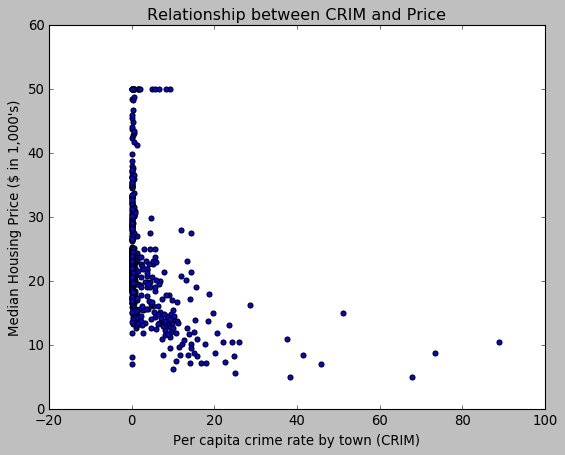

In [384]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Median Housing Price ($ in 1,000's)")
plt.title("Relationship between CRIM and Price")
plt.show()

<div class="span5 alert alert-info">

Exercise: What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?

Observations:

1. negative correlation between per capita crime rate by town and price. AS the crime rate increases, median housing price decreases.There is a negative correlation between home prices and crime per capita for median home values between \\$15,000 and about \\$30,000. 

1. Above \\$30,000, crime holds steadily low. Below about \\$15,000, crime rates are largely independent of house prices.

1. The plot does not look like linear and it looks like nonlinear behaviour. 

1. small number of points scattered where high crime rate > 40

1. At zero crime rate, median price ranges from low to high

1. large data points scattered around crime rate < 25

1. Housing prices are capped at a median value of \\$50,000.

1. There are some extreme outliers beyond a per capita crime rate of about 25, but they do not appear to be correlated to the median home value.


</div>

<div class="span5 alert alert-info">


Exercise: What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?


Exercise: Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.

Exercise: What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.

</div>


<div class="span5 alert alert-info">

Exercise: Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. Label your axes appropriately using human readable labels. Tell a story about what you see.
    
Exercise: What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? Is there anything else strange or interesting about the data? What about outliers?

</div>

In [385]:
# Calculate Peason's R for each feature:

correlation = bos.corr()
correlation.iloc[[-1]]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
PRICE,-0.388305,0.360445,-0.483725,0.17526,-0.427321,0.69536,-0.376955,0.249929,-0.381626,-0.468536,-0.507787,0.333461,-0.737663,1.0


Text(0.5, 1.0, 'Relationship between RM and Price')

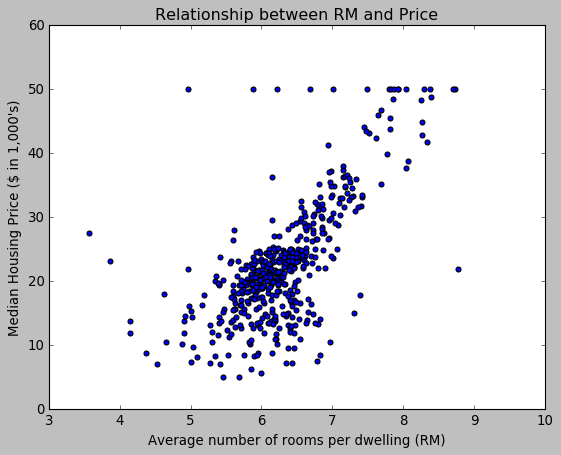

In [386]:
# your turn: scatter plot between *RM* and *PRICE*
plt.scatter(bos.RM, bos.PRICE)
plt.xlabel("Average number of rooms per dwelling (RM)")
plt.ylabel("Median Housing Price ($ in 1,000's)")
plt.title("Relationship between RM and Price")

<div class="span5 alert alert-info">
    
Observations:

1. Overall average number of rooms per dwelling increases median housing price increases. 

1. There is only one point with room number ~9 with low median price. 

2. few points are lying lying horizontal without change in median price

</div>



Text(0.5, 1.0, 'Relationship between PTRATIO and Price')

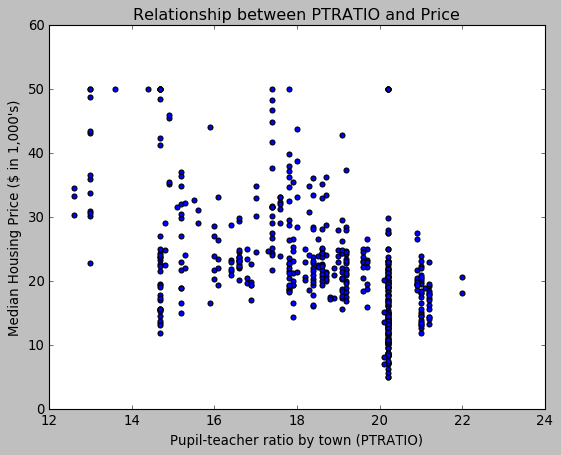

In [387]:
# your turn: scatter plot between *PTRATIO* and *PRICE*
plt.scatter(bos.PTRATIO, bos.PRICE)
plt.xlabel("Pupil-teacher ratio by town (PTRATIO)")
plt.ylabel("Median Housing Price ($ in 1,000's)")
plt.title("Relationship between PTRATIO and Price")


<div class="span5 alert alert-info">
  
Observations:

1. While there are outliers in each direction, there is a strong, positive correlation between the average number of rooms per dwelling and the median home price.

1. There is a negative correlation between the pupil-teacher ratio and median home value; as the ratio grows larger, the median home values decrease.

</div>

Text(0.5, 1.0, 'Relationship between LSTAT and Price')

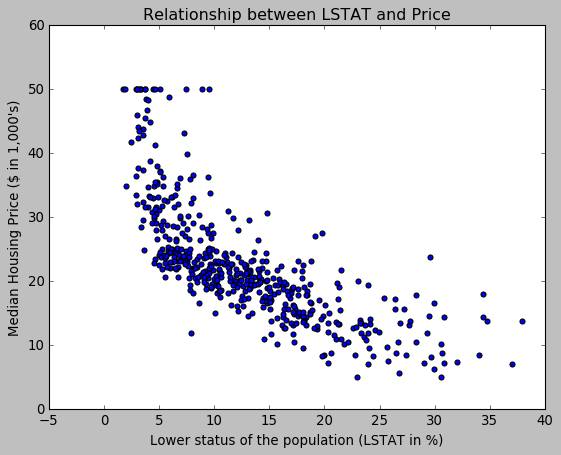

In [388]:
# your turn: scatter plot between *LSTAT* and *PRICE*
plt.scatter(bos.LSTAT, bos.PRICE)
plt.xlabel("Lower status of the population (LSTAT in %)")
plt.ylabel("Median Housing Price ($ in 1,000's)")
plt.title("Relationship between LSTAT and Price")


<div class="span5 alert alert-info">
        
Observations:

1. AS lower status of the population increases median price decreases but not linearly.

2. less than 5% LSTAT, median prices are from 20000 to 50000

</div>


### Scatterplots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

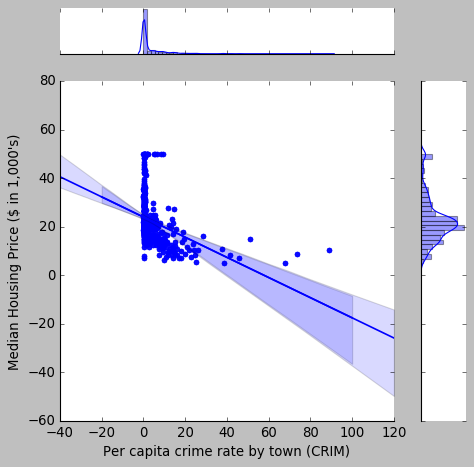

In [389]:
sns.jointplot('CRIM', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(x="CRIM", y="PRICE", data=bos, fit_reg = True)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

Text(0.5, 23.999999999999936, 'Average number of rooms per dwelling (RM)')

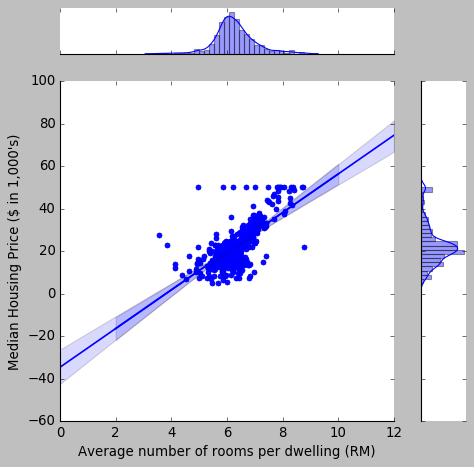

In [390]:
sns.jointplot('RM', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)
plt.ylabel("Median Housing Price ($ in 1,000's)")
plt.xlabel("Average number of rooms per dwelling (RM)")


1. positive correlation between number of rooms and median price



Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

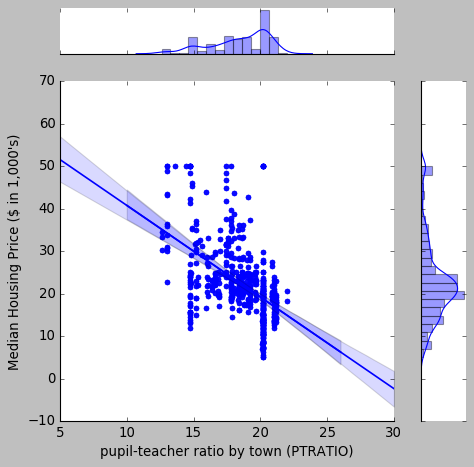

In [391]:
sns.jointplot('PTRATIO', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="PTRATIO", data=bos, fit_reg = True)
plt.xlabel("pupil-teacher ratio by town (PTRATIO)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

<div class="span5 alert alert-info">
    
<p><b>Exercise:</b> What are some other numeric variables of interest? Why do you think they are interesting? Plot scatterplots with these variables and *PRICE* (house price) and tell a story about what you see.</p>

</div>

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

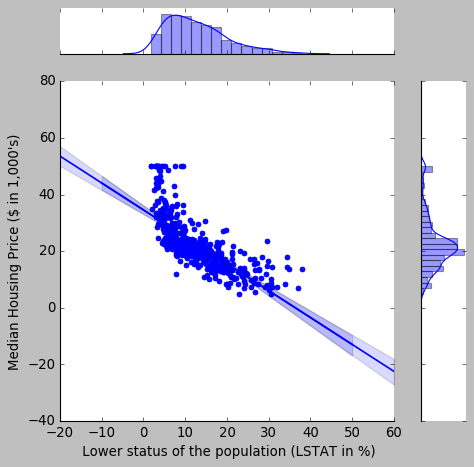

In [392]:
sns.jointplot('LSTAT', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="LSTAT", data=bos, fit_reg = True)
plt.xlabel(" Lower status of the population (LSTAT in %)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

<div class="span5 alert alert-info">

1. There is a negative correlation between economic status and median housing price. 

1. Median home values are lower in areas where larger percentages of the population are members of the lower economic classes.

</div>

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

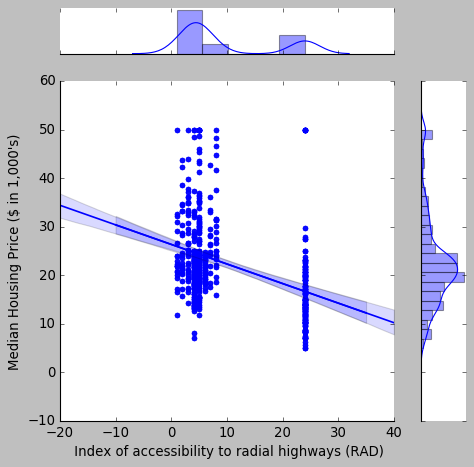

In [393]:
sns.jointplot('RAD', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="RAD", data=bos, fit_reg = True)
plt.xlabel(" Index of accessibility to radial highways (RAD)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

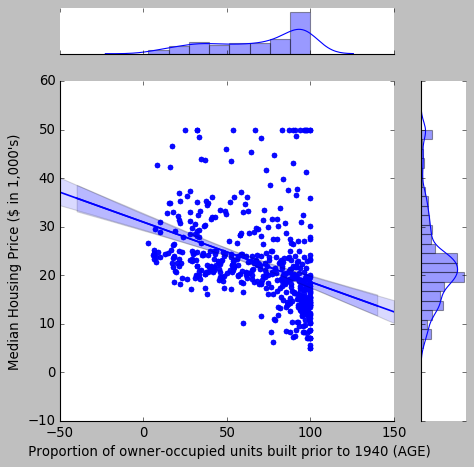

In [394]:
sns.jointplot('AGE', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="AGE", data=bos, fit_reg = True)
plt.xlabel(" Proportion of owner-occupied units built prior to 1940 (AGE)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

<div class="span5 alert alert-info">

    
1. There is a slight negative correlation between the median home values and the age of a town.
    
1. Towns with larger percentages of older units have slightly lower median values.

</div>

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

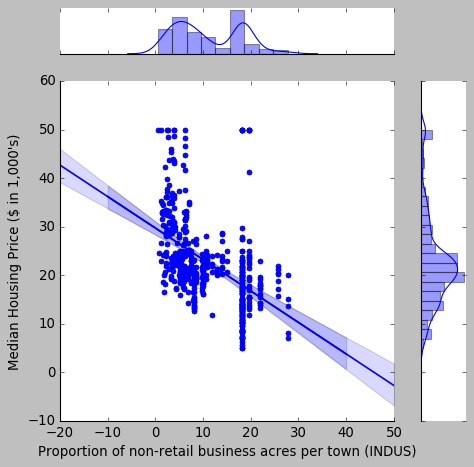

In [395]:
sns.jointplot('INDUS', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="INDUS", data=bos, fit_reg = True)
plt.xlabel("Proportion of non-retail business acres per town (INDUS)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

<div class="span5 alert alert-info">

    
1. There is a negative correlation between the median home values and the proportion of non-retail business space

1. Areas with larger percentages of non-retail business space have lower median values.
</div>

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

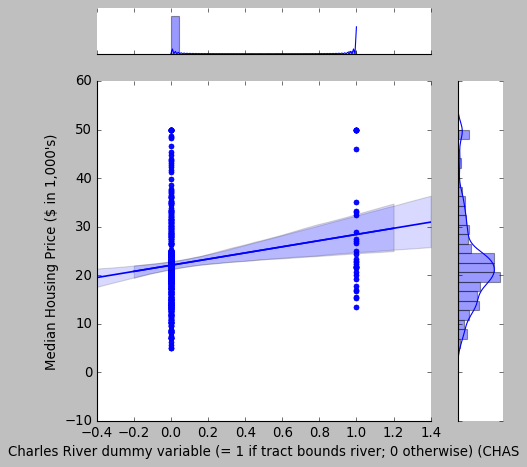

In [396]:
sns.jointplot('CHAS', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="CHAS", data=bos, fit_reg = True)
plt.xlabel("Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) (CHAS")
plt.ylabel("Median Housing Price ($ in 1,000's)")

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

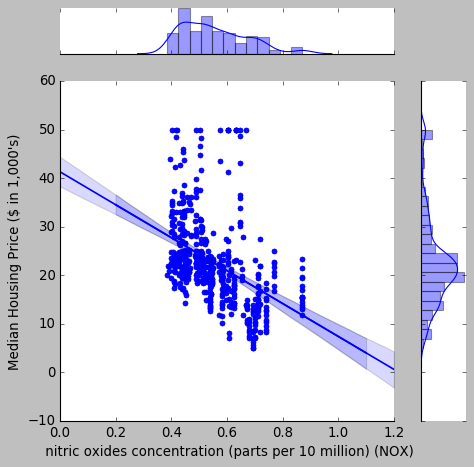

In [397]:
sns.jointplot('NOX', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="NOX", data=bos, fit_reg = True)
plt.xlabel(" nitric oxides concentration (parts per 10 million) (NOX)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

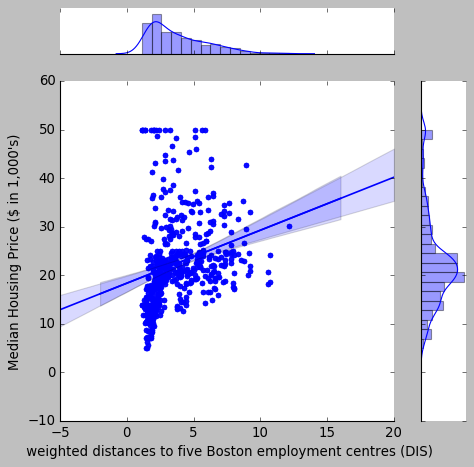

In [398]:
sns.jointplot('DIS', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="DIS", data=bos, fit_reg = True)
plt.xlabel(" weighted distances to five Boston employment centres (DIS)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

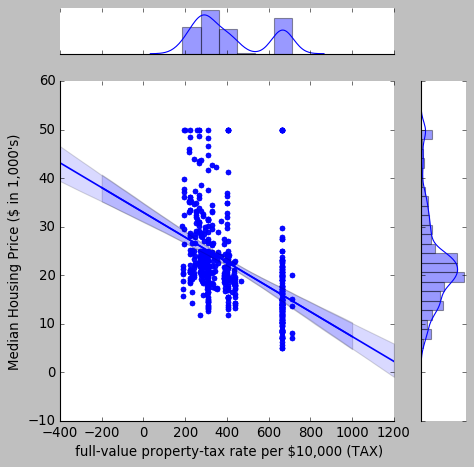

In [399]:
sns.jointplot('TAX', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="TAX", data=bos, fit_reg = True)
plt.xlabel(" full-value property-tax rate per $10,000 (TAX)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

Text(28.875, 0.5, "Median Housing Price ($ in 1,000's)")

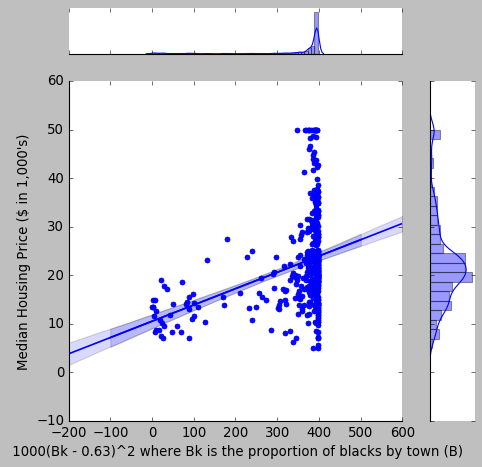

In [400]:
sns.jointplot('B', 'PRICE', data = bos, kind = 'reg', space=0.6)
sns.regplot(y="PRICE", x="B", data=bos, fit_reg = True)
plt.xlabel(" 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town (B)")
plt.ylabel("Median Housing Price ($ in 1,000's)")

### Histograms
***


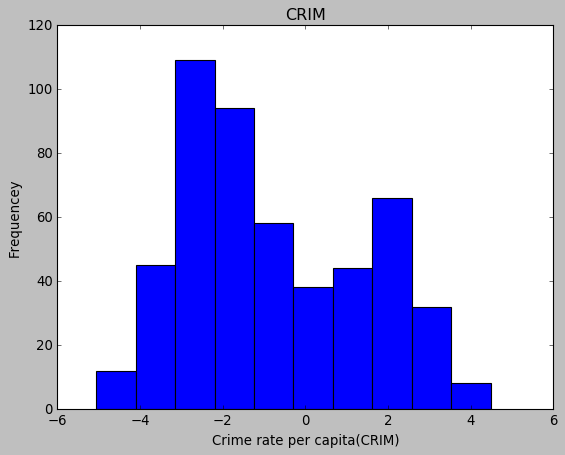

In [401]:
#CRIM histogram with log transformation
plt.hist(np.log(bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita(CRIM)")
plt.ylabel("Frequencey")
plt.show()

<div class="span5 alert alert-info">

<h3>Part 2 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

<p><b>Exercise:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>

</div>


<div class="span5 alert alert-info">

    
<p><b>Exercise:</b> In the above histogram, we took the logarithm of the crime rate per capita. Repeat this histogram without taking the log. What was the purpose of taking the log? What do we gain by making this transformation? What do you now notice about this variable that is not obvious without making the transformation?

</div>

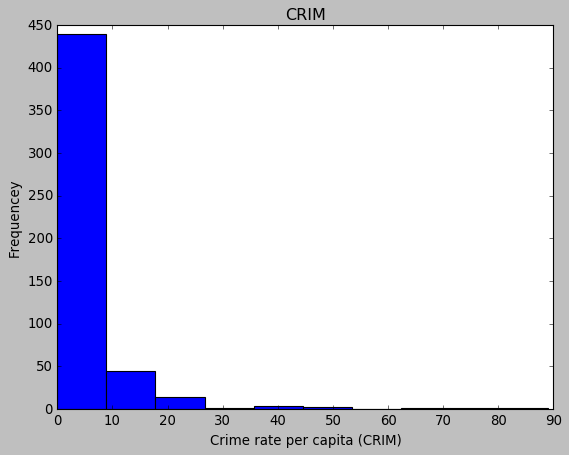

In [402]:
#your turn
#CRIM histogram without log transformation
plt.hist((bos.CRIM))
plt.title("CRIM")
plt.xlabel("Crime rate per capita (CRIM)")
plt.ylabel("Frequencey")
plt.show()

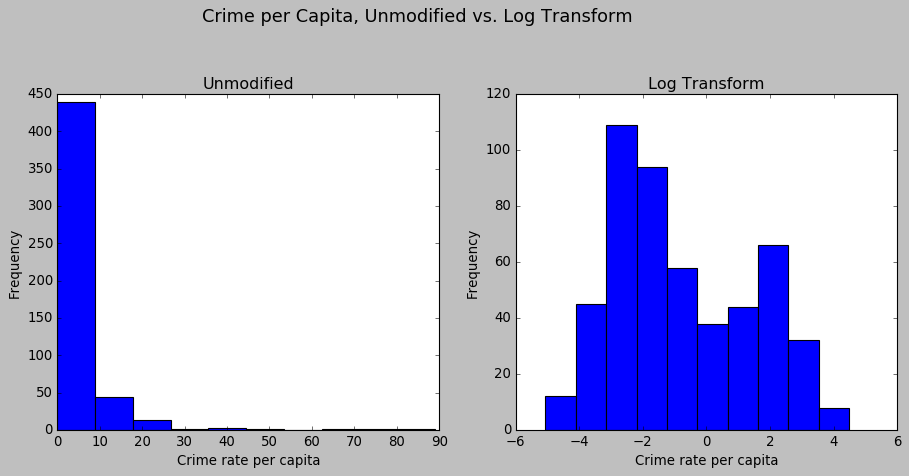

In [403]:
#comparison of log transformation and without log transformation
plt.subplots(1,2, figsize=(15,6))

plt.subplot(121)
plt.hist(bos.CRIM)
plt.title("Unmodified")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")

plt.subplot(122)
plt.hist(np.log(bos.CRIM))
plt.title("Log Transform")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequency")

plt.suptitle('Crime per Capita, Unmodified vs. Log Transform', fontsize=16)

plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)
plt.show();

<div class="span5 alert alert-info">


1. The log transformation is the most popular among the different types of transformations used to transform skewed data to approximately conform to normality. Above distribution plot shows right skewed without log transformation. After log transformation, the distribution plot looks bimodal distribution. Without log transformation, larger values of crime rate per capita distribution would not be possible to see.

1. Taking logs "pulls in" more extreme values on the right (high values) relative to the median, while values at the far left (low values) tend to get stretched back, further away from the median.

1. Taking the log of the crime rate redistributes the data to give us a different perspective. The transformed data spreads the data that was bunched at the low end of the unmodified histogram and reveals that the crime rate per capita is bimodal.
</div>

<div class="span5 alert alert-info">


<p><b>Exercise:</b> Plot the histogram for *RM* and *PTRATIO* against each other, along with the two variables you picked in the previous section. We are looking for correlations in predictors here.</p>
</div>



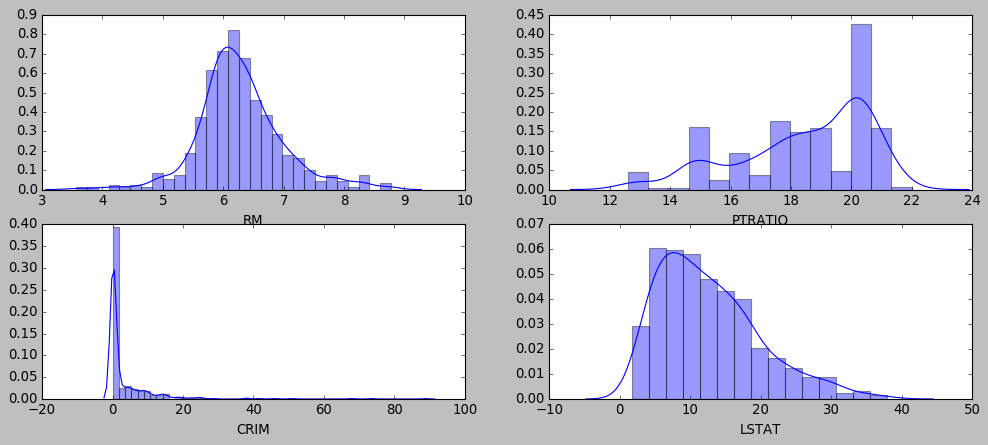

In [404]:
#histogram for RM and PTRATIO

fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(15,6))
sns.distplot(bos.RM, label='RM',ax=axs[0][0])

sns.distplot(bos.PTRATIO,label='PTRATIO',ax=axs[0][1])

sns.distplot(bos.CRIM,label='CRIM',ax=axs[1][0])

sns.distplot(bos.LSTAT,label='LSTAT',ax=axs[1][1])

#fig.tight_layout()

Scatter plot is the best one if we want to look for correlations between predictors. So here is the scatter plot of the predictors RM and PTRATIO:

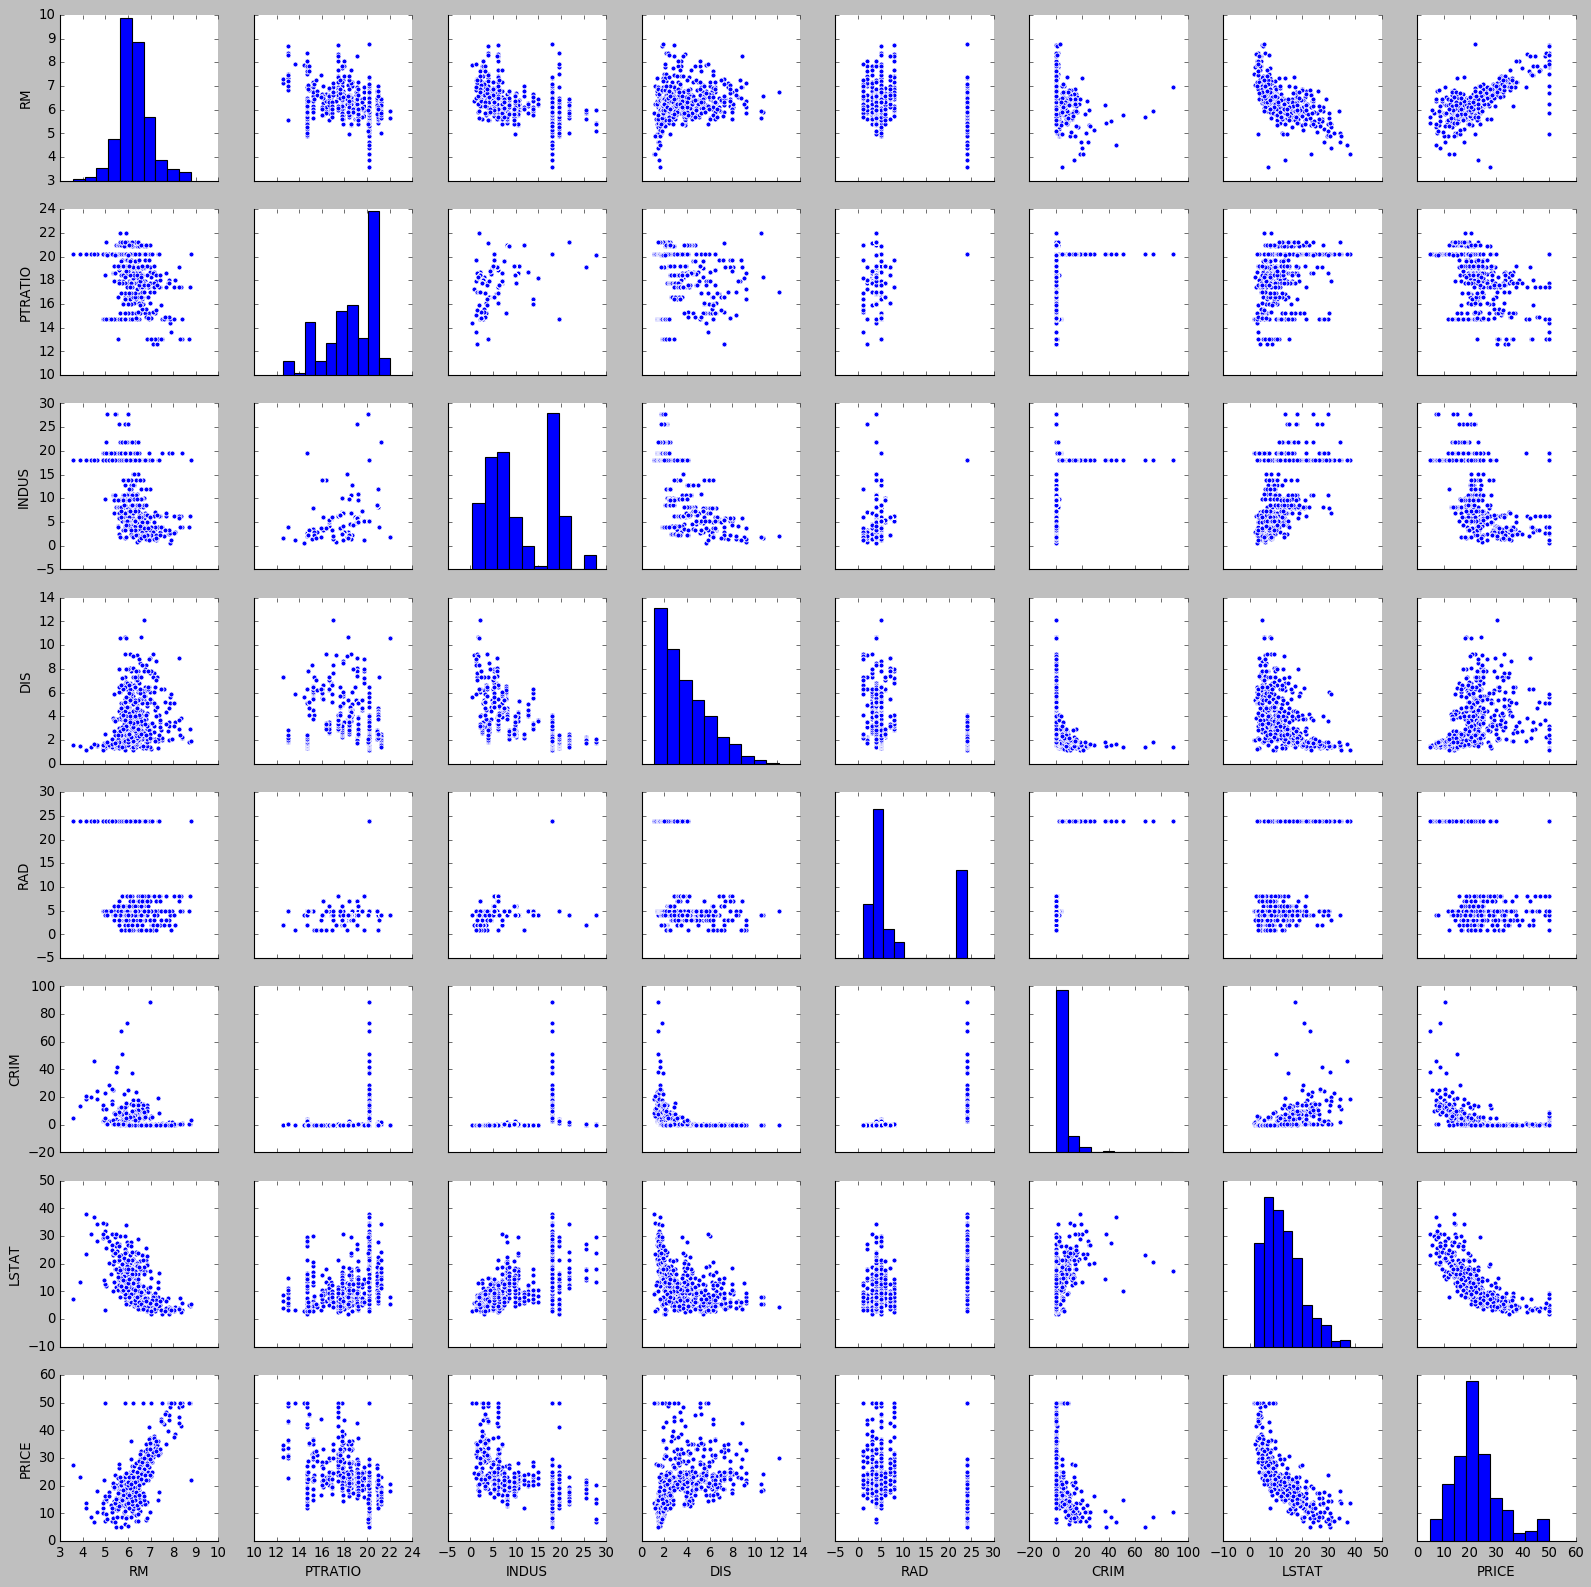

In [405]:
sns.pairplot(bos, vars=['RM', 'PTRATIO', 'INDUS', 'DIS', 'RAD', 'CRIM','LSTAT','PRICE'])
plt.show()

Text(0.5, 1.0, 'Pupil Teacher Ratio versus Avg Number of Rooms')

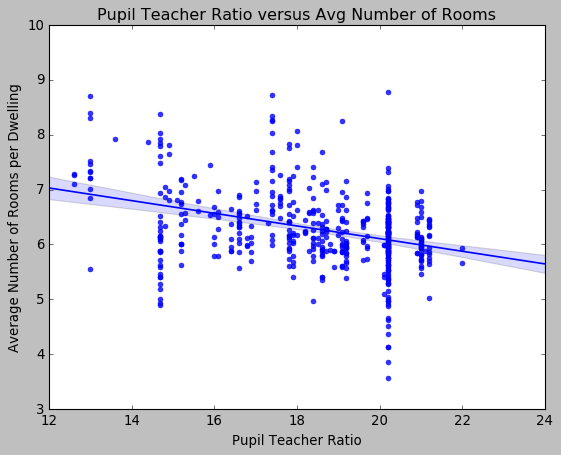

In [406]:
#scatter plot of the predictors RM and PTRATIO
sns.regplot(y='RM', x='PTRATIO', data=bos, fit_reg = True)
plt.ylabel('Average Number of Rooms per Dwelling')
plt.xlabel('Pupil Teacher Ratio')
plt.title('Pupil Teacher Ratio versus Avg Number of Rooms')

Text(0.5, 0, 'Proprtion of Lower Status Population')

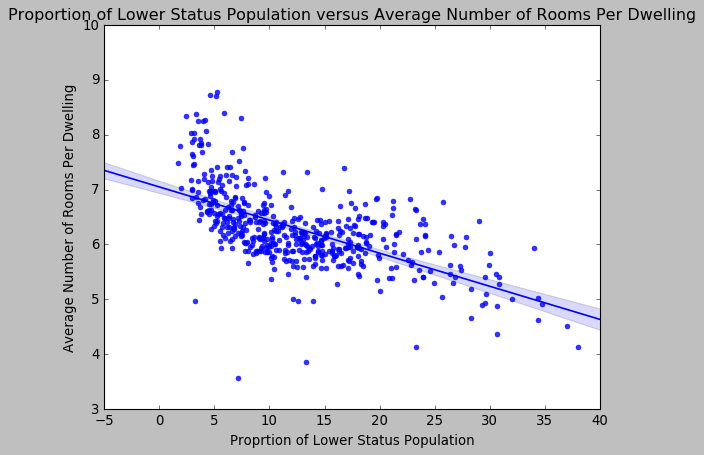

In [407]:
#scatter plot of the predictors RM and LSTAT
sns.regplot(y='RM', x='LSTAT', data=bos, fit_reg = True)
plt.title('Proportion of Lower Status Population versus Average Number of Rooms Per Dwelling')
plt.ylabel('Average Number of Rooms Per Dwelling')
plt.xlabel('Proprtion of Lower Status Population')

Text(0.5, 1.0, 'Lots Zoned for Over 25,000 sq.ft. versus Avg Number of Rooms')

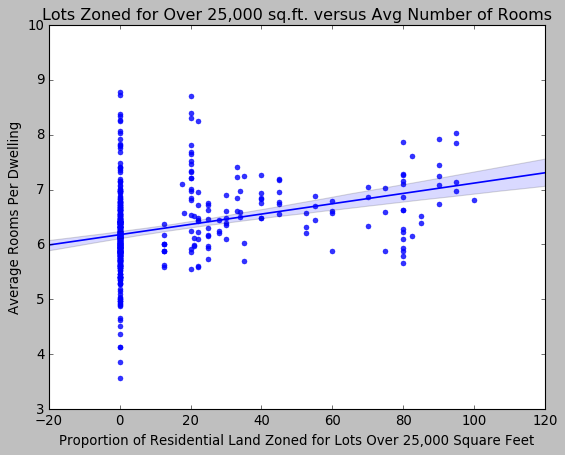

In [408]:
sns.regplot(y='RM', x='ZN', data=bos, fit_reg = True)
plt.ylabel('Average Rooms Per Dwelling')
plt.xlabel('Proportion of Residential Land Zoned for Lots Over 25,000 Square Feet')
plt.title('Lots Zoned for Over 25,000 sq.ft. versus Avg Number of Rooms')

Text(0.5, 1.0, 'Property Tax versus Avg Number of Rooms')

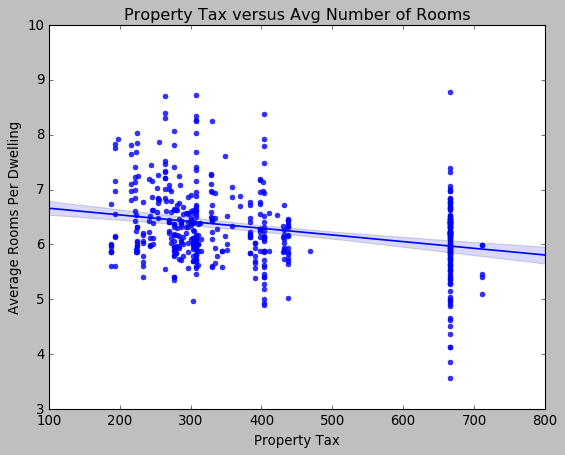

In [409]:
sns.regplot(y='RM', x='TAX', data=bos, fit_reg = True)
plt.ylabel('Average Rooms Per Dwelling')
plt.xlabel('Property Tax')
plt.title('Property Tax versus Avg Number of Rooms')

## Part 3: Linear Regression with Boston Housing Data Example
***

Here, 

$Y$ = boston housing prices (called "target" data in python, and referred to as the dependent variable or response variable)

and

$X$ = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least-squares method to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive workshop, it's a good library to have in your toolbox. Here's a quick example of what you could do with it. The version of least-squares we will use in statsmodels is called *ordinary least-squares (OLS)*. There are many other versions of least-squares such as [partial least squares (PLS)](https://en.wikipedia.org/wiki/Partial_least_squares_regression) and [weighted least squares (WLS)](https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares).

In [410]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [411]:
# statsmodels works nicely with pandas dataframes
m = ols('PRICE ~ RM',bos).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Thu, 16 May 2019   Prob (F-statistic):           2.49e-74
Time:                        23:35:16   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. This means that the number of rooms, `RM`, is a statisticall significant predictor of `PRICE`. The regression coefficient for `RM` of 9.1021 means that *on average, each additional room is associated with an increase of $\$9,100$ in house price net of the other variables*. The confidence interval gives us a range of plausible values for this average change, about ($\$8,279, \$9,925$), definitely not chump change. 

In general, the $\hat{\beta_i}, i > 0$ can be interpreted as the following: "A one unit increase in $x_i$ is associated with, on average, a $\hat{\beta_i}$ increase/decrease in $y$ net of all other variables."

On the other hand, the interpretation for the intercept, $\hat{\beta}_0$ is the average of $y$ given that all of the independent variables $x_i$ are 0.

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), but you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

In general, a formula for an OLS multiple linear regression is

`Y ~ X1 + X2 + ... + Xp`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex. You can force statsmodels to treat variables as categorical with the `C()` function, call numpy functions to transform data such as `np.log` for extremely-skewed data, or fit a model without an intercept by including `- 1` in the formula. For a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

<div class="span5 alert alert-info">

<h3>Part 3 Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a scatterplot between the predicted prices, available in `m.fittedvalues` (where `m` is the fitted model) and the original prices. How does the plot look? Do you notice anything interesting or weird in the plot? Comment on what you see.</p>
</div>

</div>

Text(0.5, 1.0, 'Actual Price versus Predicted Price')

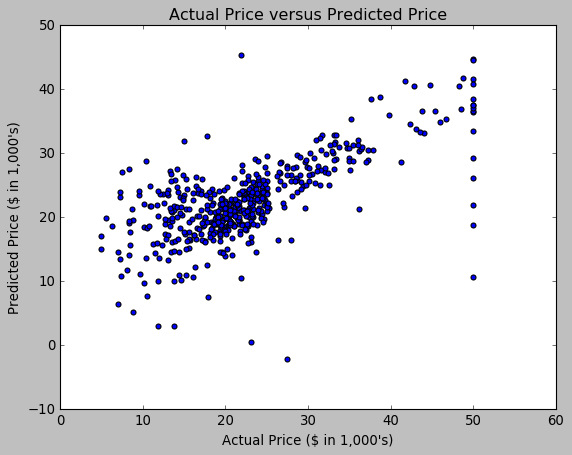

In [412]:
# your turn
plt.scatter(bos.PRICE,m.fittedvalues)
plt.ylabel("Predicted Price ($ in 1,000's)")
plt.xlabel("Actual Price ($ in 1,000's)")
plt.title('Actual Price versus Predicted Price')

<div class="span5 alert alert-info">


1. Predicted price and  actual price shows positive correlation.

2. Few odd points are scattered around. Such as negative predicted price points are scattered in the lower corner with actual price of 28000 which is suspicious.

3. Similarly, few points are lying horizontal without change in actual price.

4. One point is scattered in the right corner with high predicted price and low actual price.

5. Most of the points are scattered between price range of 10,000 to 45,000.

6. POints are fanning around left lower corner of the plot

7. large actual price > \\$50000, there is a decrease in value in predicted price


</div>


### Fitting Linear Regression using `sklearn`


In [413]:
# importing regression models in scikit
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here. Most machine learning models in scikit-learn follow this same API of fitting a model with `fit`, making predictions with `predict` and the appropriate scoring function `score` for each model.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [414]:
# Look inside lm object
lm.score

<bound method RegressorMixin.score of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [415]:
# 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [416]:
# finding intercept
lm.intercept_


36.459488385089685

In [417]:
# finding predictors coefficients
lm.coef_


array([-1.08011358e-01,  4.64204584e-02,  2.05586264e-02,  2.68673382e+00,
       -1.77666112e+01,  3.80986521e+00,  6.92224640e-04, -1.47556685e+00,
        3.06049479e-01, -1.23345939e-02, -9.52747232e-01,  9.31168327e-03,
       -5.24758378e-01])

In [418]:
# finding score
lm.score(X,bos.PRICE)


0.7406426641094094

In [419]:
lm.get_params(deep=True)


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

<div class="span5 alert alert-info">

<h3>Part 3 Checkup Exercise Set II</h3>

<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>
</div>



<div class="span5 alert alert-info">


<p><b>Exercise:</b> How would you change the model to not fit an intercept term? Would you recommend not having an intercept? Why or why not? For more information on why to include or exclude an intercept, look [here](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-is-regression-through-the-origin/).</p>

</div>

In [420]:
# your turn
# set fit_intercept=False to get an Regression Through Origin result with no y intercept
lm2 = LinearRegression(fit_intercept=False)
lm2.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [421]:
lm2.coef_

array([-9.28965170e-02,  4.87149552e-02, -4.05997958e-03,  2.85399882e+00,
       -2.86843637e+00,  5.92814778e+00, -7.26933458e-03, -9.68514157e-01,
        1.71151128e-01, -9.39621540e-03, -3.92190926e-01,  1.49056102e-02,
       -4.16304471e-01])

In [422]:
lm2.intercept_


0.0

In [423]:
lm2.score(X,bos.PRICE)

0.7137381380515404

Text(0, 0.5, 'Frequency')

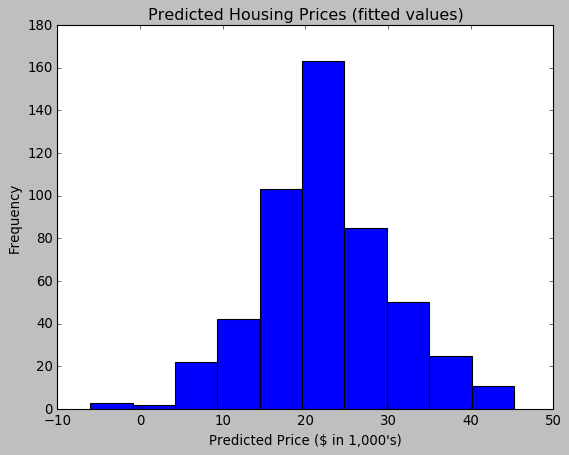

In [424]:
plt.hist(lm2.predict(X))
plt.title('Predicted Housing Prices (fitted values)')
plt.xlabel("Predicted Price ($ in 1,000's)")
plt.ylabel('Frequency')

Text(0.5, 1.0, 'Actual Price versus Predicted Price')

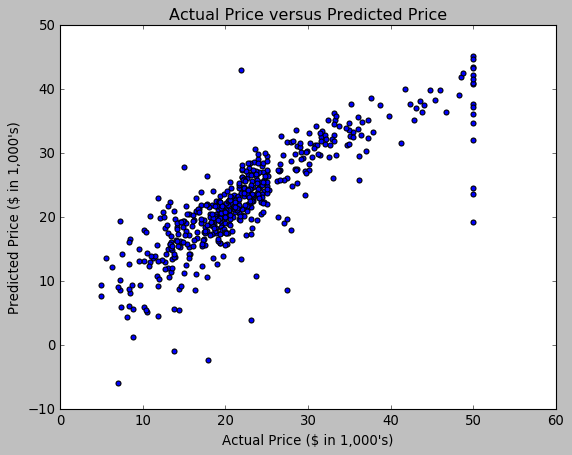

In [425]:
# your turn
plt.scatter(bos.PRICE, lm2.predict(X))
plt.ylabel("Predicted Price ($ in 1,000's)")
plt.xlabel("Actual Price ($ in 1,000's)")
plt.title('Actual Price versus Predicted Price')

In [426]:
# Let's look at the first five predicted values with the RTO model
lm2.predict(X)[0:5]

array([29.09826353, 24.50227548, 31.22742641, 29.7071035 , 29.56479572])

<div class="span5 alert alert-info">


1. There are no houses with actual price of \\$0 or values near \\$0. There will be minimum price for the house that will be above zero that leads to positive intercept.

1. In this case, regression through origin model does not make sense.

</div>


<div class="span5 alert alert-info">


<p><b>Exercise:</b> One of the assumptions of the linear model is that the residuals must be i.i.d. (independently and identically distributed). To satisfy this, is it enough that the residuals are normally distributed? Explain your answer.</p>

In order to use OLS regression, the residuals must:
1. be independent
1. have constant variance
1. be normally distributed

IID refers to the first two criteria. Normally distributed residuals need not necessarily be independent or have constant variance.

</div>

<div class="span5 alert alert-info">


<p><b>Exercise:</b> True or false. To use linear regression, $Y$ must be normally distributed. Explain your answer.</p>

False.Y does not need to be normally distributed to use linear regression. In order to make inferences about the regression parameters, it is adequate to know that the regression coefficient estimates are consistent and asymptotically normal. Confidence intervals for parameter estimates can be obtained using normality, even if the response is not normally distributed, as long as the sample size is in the asymptotic region ("large enough"). There are four principal assumptions which justify the use of linear regression models for purposes of inference or prediction:

1. linearity and additivity of the relationship between dependent and independent variables:

    A. The expected value of dependent variable is a straight-line function of each independent variable, holding the others fixed.
    
    B. The slope of that line does not depend on the values of the other variables.
    
    C. The effects of different independent variables on the expected value of the dependent variable are additive.
    
2. statistical independence of the errors (in particular, no correlation between consecutive errors in the case of 
time series data)

3. homoscedasticity (constant variance) of the errors

    A. versus time (in the case of time series data)
    
    B. versus the predictions
    
    C. versus any independent variable
    
4. normality of the error distribution.

</div>

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [427]:
print('Estimated intercept coefficient: {}'.format(lm.intercept_))

Estimated intercept coefficient: 36.459488385089685


In [428]:
print('Number of coefficients: {}'.format(len(lm.coef_)))

Number of coefficients: 13


In [429]:
# The coefficients
pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [430]:
# first five predicted prices
lm.predict(X)[0:5]

array([30.00384338, 25.02556238, 30.56759672, 28.60703649, 27.94352423])

<div class="span5 alert alert-info">

<h3>Part 3 Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>

<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>
</div>


<div class="span5 alert alert-info">


<p><b>Exercise:</b> Histogram: Plot a histogram of all the predicted prices. Write a story about what you see. Describe the shape, center and spread of the distribution. Are there any outliers? What might be the reason for them? Should we do anything special with them?</p>

</div>

Text(0.5, 0, "Predicted Price ($ in 1,000's)")

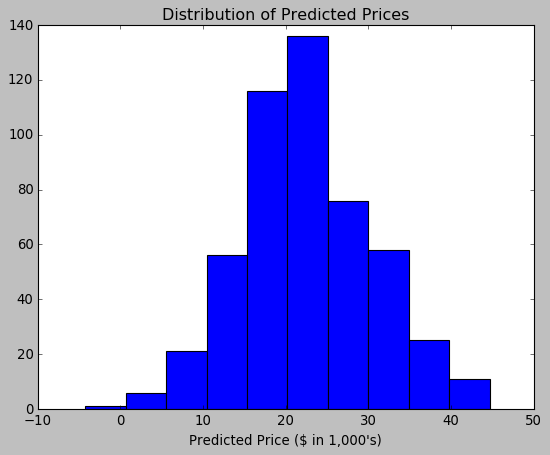

In [431]:
# your turn
plt.hist(lm.predict(X))
plt.title('Distribution of Predicted Prices')
plt.xlabel("Predicted Price ($ in 1,000's)")

In [432]:
df = lm.predict(X)
dfnew=pd.DataFrame(df)
dfnew.describe()

,0
count,506.000000
mean,22.532806
std,7.915083
min,-4.281311
25%,17.445740
50%,22.118653
75%,27.410022
max,44.673083


<div class="span5 alert alert-info">


1. The median predicted price is \\$22120.

2. Distribution of predicted price is symmetrical.

3. mean predicted price is  \\$22500 and std is 7.9

4. here the mean is slightly greater than median. the above distribution is slightly right skewed. right side is relatively higher values compared to left side

5. The negative values may be considered outliers as a predicted price below zero is not a valid data point. This may be due to the fact that the model is not accurate for values near zero since in the real world there are no home prices of zero. Also minimum price is \\$ -4281. We should look more closely to see if we can resolve or eliminate these predictions.

6. IQR is 27-17 = 10

</div>


<div class="span5 alert alert-info">


<p><b>Exercise:</b> Scatterplot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).</p>
   
</div>


Text(0.5, 1.0, 'Actual Price versus Predicted Price')

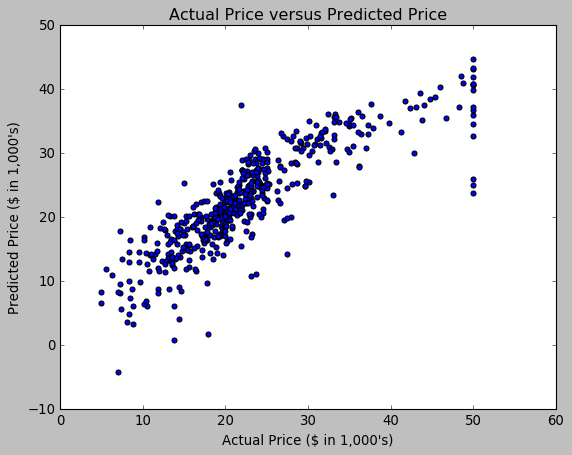

In [433]:
#model using scikit
plt.scatter(bos.PRICE,lm.predict(X))
plt.ylabel("Predicted Price ($ in 1,000's)")
plt.xlabel("Actual Price ($ in 1,000's)")
plt.title('Actual Price versus Predicted Price')

<div class="span5 alert alert-info">


<p><b>Exercise:</b> We have looked at fitting a linear model in both `statsmodels` and `scikit-learn`. What are the advantages and disadvantages of each based on your exploration? Based on the information provided by both packages, what advantage does `statsmodels` provide?</p>

</div>

<div class="span5 alert alert-info">


Statsmodel advantages:
1. After you fit the model, unlike with statsmodels, SKLearn does not automatically print the concepts or have a method like summary. So we have to print the coefficients separately. While SKLearn isn’t as intuitive for printing/finding coefficients, .

2. The main benefit of statsmodels is the other statistics it provides. One of the assumptions of a simple linear regression model is normality of our data.If the Prob(Omnibus) is very small, and I took this to mean <.05 as this is standard statistical practice, then our data is probably not normal. This is a more precise way than graphing our data to determine if our data is normal.

3. Statsmodels also helps us determine which of our variables are statistically significant through the p-values. If our p-value is <.05, then that variable is statistically significant. This is a useful tool to tune your model.

SKLearn advantages:

1. SKLearn is much easier to use for cross-validation and plotting models

2. Since SKLearn has more useful features, I would use it to build your final model, but statsmodels is a good method to analyze your data before you put it into your model.

</div>

### Evaluating the Model: Sum-of-Squares

The partitioning of the sum-of-squares shows the variance in the predictions explained by the model and the variance that is attributed to error.

$$TSS = ESS + RSS$$

#### Residual Sum-of-Squares (aka $RSS$)

The residual sum-of-squares is one of the basic ways of quantifying how much error exists in the fitted model. We will revisit this in a bit.

$$ RSS = \sum_{i=1}^N r_i^2 = \sum_{i=1}^N \left(y_i - \left(\beta_0 + \beta_1 x_i\right)\right)^2 $$

In [434]:
RSS = np.sum((bos.PRICE - lm.predict(X)) ** 2)
print(RSS)

11078.784577954979


#### Explained Sum-of-Squares (aka $ESS$)

The explained sum-of-squares measures the variance explained by the regression model.

$$ESS = \sum_{i=1}^N \left( \hat{y}_i - \bar{y} \right)^2 = \sum_{i=1}^N \left( \left( \hat{\beta}_0 + \hat{\beta}_1 x_i \right) - \bar{y} \right)^2$$

In [435]:
ESS = (np.sum(lm.predict(X) - np.mean(bos.PRICE)) ** 2)
print(ESS)

1.4522189629134092e-22


In [436]:
# calculating sum o squares
TSS = ESS+RSS
print(TSS)

11078.784577954979


### Evaluating the Model: The Coefficient of Determination ($R^2$)

The coefficient of determination, $R^2$, tells us the percentage of the variance in the response variable $Y$ that can be explained by the linear regression model.

$$ R^2 = \frac{ESS}{TSS} $$

The $R^2$ value is one of the most common metrics that people use in describing the quality of a model, but it is important to note that *$R^2$ increases artificially as a side-effect of increasing the number of independent variables.* While $R^2$ is reported in almost all statistical packages, another metric called the *adjusted $R^2$* is also provided as it takes into account the number of variables in the model, and can sometimes even be used for non-linear regression models!

$$R_{adj}^2 = 1 - \left( 1 - R^2 \right) \frac{N - 1}{N - K - 1} = R^2 - \left( 1 - R^2 \right) \frac{K}{N - K - 1} = 1 - \frac{\frac{RSS}{DF_R}}{\frac{TSS}{DF_T}}$$

where $N$ is the number of observations, $K$ is the number of variables, $DF_R = N - K - 1$ is the degrees of freedom associated with the residual error and $DF_T = N - 1$ is the degrees of the freedom of the total error.

### Evaluating the Model: Mean Squared Error and the $F$-Statistic
***
The mean squared errors are just the *averages* of the sum-of-squares errors over their respective degrees of freedom.

$$MSE = \frac{RSS}{N-K-1}$$

$$MSR = \frac{ESS}{K}$$

**Remember:** Notation may vary across resources particularly the use of $R$ and $E$ in $RSS/ESS$ and $MSR/MSE$. In some resources, E = explained and R = residual. In other resources, E = error and R = regression (explained). **This is a very important distinction that requires looking at the formula to determine which naming scheme is being used.**

Given the MSR and MSE, we can now determine whether or not the entire model we just fit is even statistically significant. We use an $F$-test for this. The null hypothesis is that all of the $\beta$ coefficients are zero, that is, none of them have any effect on $Y$. The alternative is that *at least one* $\beta$ coefficient is nonzero, but it doesn't tell us which one in a multiple regression:

$$H_0: \beta_i = 0, \mbox{for all $i$} \\
H_A: \beta_i > 0, \mbox{for some $i$}$$ 

$$F = \frac{MSR}{MSE} = \left( \frac{R^2}{1 - R^2} \right) \left( \frac{N - K - 1}{K} \right)$$
 
Once we compute the $F$-statistic, we can use the $F$-distribution with $N-K$ and $K-1$ degrees of degrees of freedom to get a p-value.

**Warning!** The $F$-statistic mentioned in this section is NOT the same as the F1-measure or F1-value discused in Unit 7.

In [437]:
# K is number of variables, N is the number of observations
N = len(bos)
K =len(lm.coef_)


In [438]:
# calculate the coefficient of determination r2

r_r = ESS/TSS
print(r_r)

1.3108107235906494e-26


In [439]:
#calculate mean squared error
mse = (RSS)/(N-K-1)
print(mse)

22.517854833241827


In [440]:
# calculating msr
msr = ESS/K
print(msr)

1.1170915099333916e-23


In [441]:
# calcuclate the F statistic
F = msr/mse
F

4.960914430819996e-25

<div class="span5 alert alert-info">

<h3>Part 3 Checkup Exercise Set IV</h3>

<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

<p><b>Exercise:</b> Take a close look at the $F$-statistic and the $t$-statistic for the regression coefficient. What relationship do you notice? Note that this relationship only applies in *simple* linear regression models.</p>
</div>


<div class="span5 alert alert-info">


<p>Let's look at the relationship between `PTRATIO` and housing price.</p>

</div>

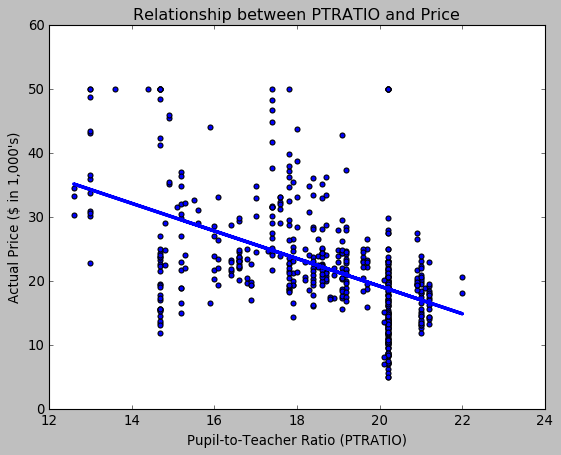

In [442]:
plt.scatter(bos.PTRATIO, bos.PRICE)
plt.xlabel("Pupil-to-Teacher Ratio (PTRATIO)")
plt.ylabel("Actual Price ($ in 1,000's)")
plt.title("Relationship between PTRATIO and Price")
X_PT = bos.PTRATIO
X_PT = X_PT.values.reshape(-1,1)
lm.fit(X_PT, bos.PRICE)
plt.plot(bos.PTRATIO, lm.predict(X_PT), color='blue', linewidth=3)
plt.show()

<div class="span5 alert alert-info">


There is a strong negative correlation between the teacher-pupil ratio and median home value; as the number of students per teacher increases, the median home value decreases, indicating that schools in towns with lower median home values have larger class sizes.

</div>

<div class="span5 alert alert-info">


<p><b>Exercise:</b> Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town) and interpret the intercept and the coefficients.</p>

<p><b>Exercise:</b> Calculate (or extract) the $R^2$ value. What does it tell you?</p>

<p><b>Exercise:</b> Compute the $F$-statistic. What does it tell you?</p>

</div>

In [443]:
m_2 = ols('PRICE ~ PTRATIO', bos).fit()
m_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     175.1
Date:                Thu, 16 May 2019   Prob (F-statistic):           1.61e-34
Time:                        23:35:17   Log-Likelihood:                -1764.8
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     504   BIC:                             3542.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     62.3446      3.029     20.581      0.000      56.393      68.296
PTRATIO       -2.1572      0.163    -13.233      0.000      -2.477      -1.837
==============================================================================
Omnibus:                       92.924   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.444
Skew:                           1.001   Prob(JB):                     2.68e-42
Kurtosis:                       5.252   Cond. No.                         160.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [444]:
print('\n\nR^2: {}'.format(m_2.rsquared))
print('F-statistic: {}'.format(m_2.fvalue))



R^2: 0.257847318009223
F-statistic: 175.1055428756955


<div class="span5 alert alert-info">

    
Intercept & Coefficients

1. Y intercept value is 62.34 and the coefficient (slope) is -2.16. The coefficient is the slope and the intercept is the y-intercept.

2. As the PTRATIO increases by 1, the price decreases by approximately \\$2,157 . 

3. If the PTRATIO is 0, then the model predicts that the median house price will be ~\\$63000
 
4. The y-intercept corresponds with PTRATIO~0. In reality, there is no PTRATIO of 0, so the model is not a good estimate of PTRATIO values that approach 0.If data with X values near zero would not make sense, then usually the interpretation of the intercept won't seem realistic in the world. It is however acceptable to interpret this as a coefficient in the model.

5. Samples taken in a similar fashion will result in y-intercepts between \\$56,393 and \\$68,296 95% of the time.


The R2(the Coefficient of Determination) statistic is one of two measures of the quality of a linear regression fit, the other being RSE, or Residual Standard Error. R2 measures the proportion of variability in Y that can be explained using X. R2 is always between 0 and 1 and is independent of the scale of Y. As the R2 value approaches 1, it indicates that a large proportion of the variability in the response has been explained by the regression. A number closer to 0 indicates that the regression did not explain much of the variability in the response; this might occur because the model is wrong, or the inherent error σ2 is high, or both. The R2 value of 0.258 indicates that just over 25% of the variability in median home value is explained by the variability in the pupil-teacher ratio.


F-statistic & t-statistic: The F-statistic measures whether there is a relationship between the response and the predictors. If the F-statistic takes on a value close to 1, it indicates that the null hypothesis is true and that there is no relationship between the predictors and the response. If the F-statistic is greater than 1, it indicates that Ha is true, and that there is a relationship between the predictors and the response. Here, our F-statistic of 175 is much greater than 1, and indicates that there is a relationship between the pupil-teacher ratio and the median home value.

The F-statistic can be used to determine the probability that any change in outcome was due to random chance or due to the influence of a variable or group of variables. If the F statistic is greater than F-critical, then we can reject the null hypothesis that it was due to randomness and conclude that the change in outcome was affected by the variables. In this case, looking at the F-table, we see that for 1 degree of freedom in both the numerator and denominator, F critical is 175. Since F is greater than that, we can reject the null hypothesis and conclude that PTRATIO does affect PRICE.

            H0:β1=β2=...=βp=0
            Ha: at least one βj≠0

</div>

#### Exercise: Calculate (or extract) the  𝑅2  value. What does it tell you?

In [445]:
X_predict = lm.predict(X_PT)
#X_predict = X_predict.reshape(-1,1)

In [446]:
Y_PT = bos.PRICE.values.reshape(-1,1)
len(Y_PT)

506

In [447]:
# extract R**2
lm.score(X_PT, bos.PRICE)

0.257847318009223

The result can be negative which indicates a poor model.



In [448]:
# calculate R**2 = ESS/(ESS + RSS)
R_squared = np.sum((lm.predict(X_PT) - np.mean(bos.PRICE))** 2) / (np.sum((lm.predict(X_PT) - np.mean(bos.PRICE))** 2)  + 
                                                                     np.sum((bos.PRICE - lm.predict(X_PT)) ** 2))
R_squared

0.257847318009223

#### Exercise: Compute the  𝐹 -statistic. What does it tell you?

In [449]:
# set K = 1 since we have just one variable
K = 1

In [450]:
# F = (RSS/N-K-1)/(ESS/K) = Rsquared/(1 - Rsquared) * (N - K - 1)/K
F = (R_squared/(1 - R_squared)) * ((N - K - 1)/K)
F

175.10554287569548

<div class="span5 alert alert-info">

<h3>Part 3 Checkup Exercise Set V</h3>

<p>Fit a linear regression model using three independent variables</p>

<ol>
<li> 'CRIM' (per capita crime rate by town)
<li> 'RM' (average number of rooms per dwelling)
<li> 'PTRATIO' (pupil-teacher ratio by town)
</ol>

<p><b>Exercise:</b> Compute or extract the $F$-statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Compute or extract the $R^2$ statistic. What does it tell you about the model?</p>

<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>
</div>


In [451]:
# your turn
m_3 = ols('PRICE ~ PTRATIO + CRIM + RM',bos).fit()
print(m_3.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     245.2
Date:                Thu, 16 May 2019   Prob (F-statistic):           6.15e-98
Time:                        23:35:17   Log-Likelihood:                -1612.0
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     502   BIC:                             3249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3707      4.034     -0.836      0.4

<div class="span5 alert alert-info">

    
1. F-statistic: F statistic is 245. F-statistic tells us that these three variables as a group or at least one of the variables have an impact on the outcome PRICE that is statistically significant. 

1. Coefficient of Determination: R-squared = 0.594. The R-squared number tells us that 59.4% of the data fit on the model. The R2 value for the PTRATIO alone was just over 0.25, so this represents a 34% improvement in determining the variables that affect the variability of the median home value.

1. Coefficients: For each additional room, the PRICE increases approximately \\$7380. As PTRATIO increases, the PRICE decreases by approximately \\$1070 and for every percentage increase in the per capita Crime Rate, the price decreases approximately \\$205. RM predictor has significant in predicting house price.


</div>

<div class="span5 alert alert-info">


<p><b>Exercise:</b> Which variables in the model are significant in predicting house price? Write a story that interprets the coefficients.</p>

    The p-values of all three features are 0, indicating that all three are statistically-significant. The strongest correlation between one of these features and median home value is RM. It is a postive correlation, and it indicates that for each additional unit of RM, the median home value increases by \\$7,380. PTRATIO has the next highest correlation and it is negative. For each additional pupil per teacher, the median home value decreases by $1,070. CRIM also has a negative correlation, and for each unit of increase in CRIM, the median house value would decrease by \\$205.


</div>

## Part 4: Comparing Models

During modeling, there will be times when we want to compare models to see which one is more predictive or fits the data better. There are many ways to compare models, but we will focus on two.

### The $F$-Statistic Revisited

The $F$-statistic can also be used to compare two *nested* models, that is, two models trained on the same dataset where one of the models contains a *subset* of the variables of the other model. The *full* model contains $K$ variables and the *reduced* model contains a subset of these $K$ variables. This allows us to add additional variables to a base model and then test if adding the variables helped the model fit.

$$F = \frac{\left( \frac{RSS_{reduced} - RSS_{full}}{DF_{reduced} - DF_{full}} \right)}{\left( \frac{RSS_{full}}{DF_{full}} \right)}$$

where $DF_x = N - K_x - 1$ where $K_x$ is the number of variables in model $x$.

### Akaike Information Criterion (AIC)

Another statistic for comparing two models is AIC, which is based on the likelihood function and takes into account the number of variables in the model.

$$AIC = 2 K - 2 \log_e{L}$$

where $L$ is the likelihood of the model. AIC is meaningless in the absolute sense, and is only meaningful when compared to AIC values from other models. Lower values of AIC indicate better fitting models.

`statsmodels` provides the AIC in its output.

<div class="span5 alert alert-info">

<h3>Part 4 Checkup Exercises</h3>

<p><b>Exercise:</b> Find another variable (or two) to add to the model we built in Part 3. Compute the $F$-test comparing the two models as well as the AIC. Which model is better?</p>
</div>


In [452]:
m_5 = ols('PRICE ~ PTRATIO + CRIM + RM + LSTAT + DIS',bos).fit()
print(m_5.summary())

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     228.7
Date:                Thu, 16 May 2019   Prob (F-statistic):          1.10e-126
Time:                        23:35:17   Log-Likelihood:                -1539.2
No. Observations:                 506   AIC:                             3090.
Df Residuals:                     500   BIC:                             3116.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.8945      4.080      5.611      0.0

In [453]:
# create model, adding one new predictors - DIS + LSTAT

rss_reduced = m_3.ssr
rss_full = m_5.ssr
df_reduced = m_3.df_resid
df_full = m_5.df_resid
f = ((rss_reduced - rss_full)/(df_reduced - df_full))/(rss_full/df_full)
print('F-statistic is:', f)

# extract AIC's
print('AIC - reduced: \t{}\nAIC - full: \t{}\nDifference: \t{}'.format(m_3.aic, m_5.aic, m_3.aic - m_5.aic))


F-statistic is: 83.35415426764418
AIC - reduced: 	3231.9451235449956
AIC - full: 	3090.3463896931744
Difference: 	141.59873385182118


<div class="span5 alert alert-info">

    
1. Adding DIS and LSTAT to the regression equation results in a more accurate model:

1. R2 increases by about 10% (from 0.594 to 0.696), meaning that the features explain more of the variance in the target

1. AIC drops 142 points, from 3,232 to 3,090. The lower value indicates a better model.

1. F_full was 245. F_reduced was 229. F for comparison test was 83.35 indicating an improvement.

</div>




## Part 5: Evaluating the Model via Model Assumptions and Other Issues
***
Linear regression makes several assumptions. It is always best to check that these assumptions are valid after fitting a linear regression model.

<div class="span5 alert alert-danger">

<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. This can be verified with a scatterplot of each $X$ vs. $Y$ and plotting correlations among $X$. Nonlinearity can sometimes be resolved by [transforming](https://onlinecourses.science.psu.edu/stat501/node/318) one or more independent variables, the dependent variable, or both. In other cases, a [generalized linear model](https://en.wikipedia.org/wiki/Generalized_linear_model) or a [nonlinear model](https://en.wikipedia.org/wiki/Nonlinear_regression) may be warranted.</li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X. We can check this by plotting each $X$ against $Y$ and verifying that there is no "funnel" shape showing data points fanning out as $X$ increases or decreases. Some techniques for dealing with non-constant variance include weighted least squares (WLS), [robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors), or variance stabilizing transformations.
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. This can be verified with a fitted values vs. residuals plot and verifying that there is no pattern, and with a quantile plot.
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>

There are some other issues that are important investigate with linear regression models.

<div class="span5 alert alert-danger">
<ul>
  <li>**Correlated Predictors:** Care should be taken to make sure that the independent variables in a regression model are not too highly correlated. Correlated predictors typically do not majorly affect prediction, but do inflate standard errors of coefficients making interpretation unreliable. Common solutions are dropping the least important variables involved in the correlations, using regularlization, or, when many predictors are highly correlated, considering a dimension reduction technique such as principal component analysis (PCA).
  <li>**Influential Points:** Data points that have undue influence on the regression model. These points can be high leverage points or outliers. Such points are typically removed and the regression model rerun.
</ul>
</div>


<div class="span5 alert alert-info">

<h3>Part 5 Checkup Exercises</h3>

<p>Take the reduced model from Part 3 to answer the following exercises. Take a look at [this blog post](http://mpastell.com/2013/04/19/python_regression/) for more information on using statsmodels to construct these plots.</p>
    
<p><b>Exercise:</b> Construct a fitted values versus residuals plot. What does the plot tell you? Are there any violations of the model assumptions?</p>

<p><b>Exercise:</b> Construct a quantile plot of the residuals. What does the plot tell you?</p>

<p><b>Exercise:</b> What are some advantages and disadvantages of the fitted vs. residual and quantile plot compared to each other?</p>

<p><b>Exercise:</b> Identify any outliers (if any) in your model and write a story describing what these outliers might represent.</p>

<p><b>Exercise:</b> Construct a leverage plot and identify high leverage points in the model. Write a story explaining possible reasons for the high leverage points.</p>

<p><b>Exercise:</b> Remove the outliers and high leverage points from your model and run the regression again. How do the results change?</p>
</div>


Text(0.5, 1.0, 'Relationship between fitted values and residuals')

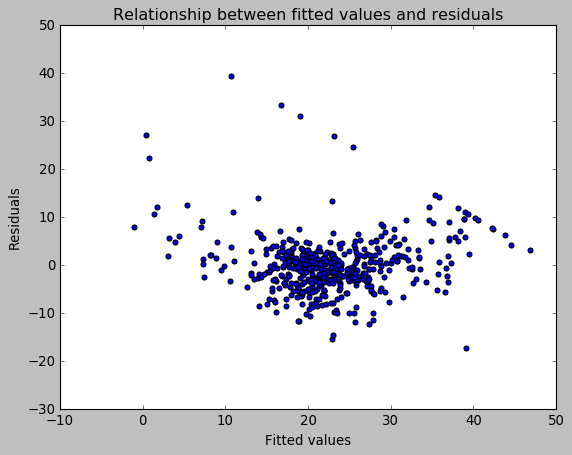

In [454]:
# construct a fitted values versus residuals plot.
plt.scatter(m_3.fittedvalues,m_3.resid)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Relationship between fitted values and residuals")

Text(0.5, 0, 'Normalized residuals')

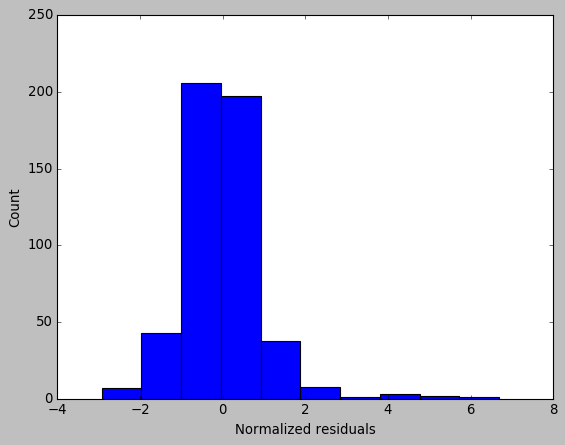

In [455]:
plt.hist(m_3.resid_pearson)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')

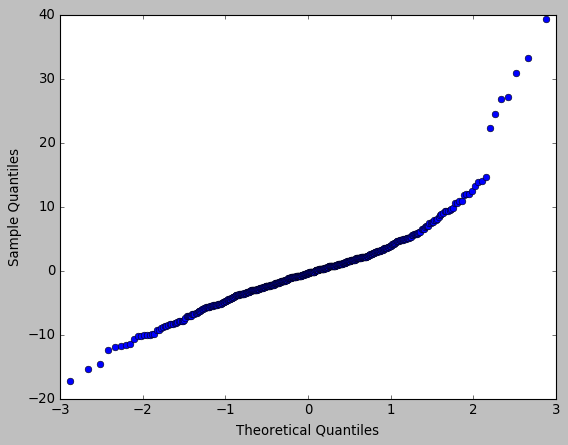

In [456]:
# create a quantile plot of the residuals
import statsmodels.api as sm
sm.qqplot(m_3.resid)
plt.show()


<div class="span5 alert alert-info">


1. The residuals are normally distributed in the middle but there are evident outliers.

1. Comparing the two plots, it easier to visualize the normality by viewing the second plot, but looking at the first one it is easier to know the approximate values of the outliers.

1. Looking at the first plot, the worst offenders occured for two points near 0, a point at 10, another close to 20, and several between 20 and 30 (predicted PRICE in thousands).

1. When looking at the plot of predicted versus actual prices, we see that there are several data points for homes whose actual prices were way higher than their predicted values. It may be that these homes had some historical significance or are in a location near a historical site or are bordering the Charles River.

1. The QQ plot shows that the residuals are normally-distributed from 0% - ~75%. The highest seven values are visually outliers.

</div>


In [457]:
# ferret out large residuals
bos['FITTED'] = m_3.fittedvalues
bos['RESIDUALS'] = m_3.resid

large_residuals = bos[bos.RESIDUALS > 20]
len(large_residuals)
large_residuals

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE,FITTED,RESIDUALS
365,4.55587,0.0,18.1,0.0,0.718,3.561,87.9,1.6132,24.0,666.0,20.2,354.70,7.12,27.5,0.372333,27.127667
367,13.52220,0.0,18.1,0.0,0.631,3.863,100.0,1.5106,24.0,666.0,20.2,131.42,13.33,23.1,0.763471,22.336529
368,4.89822,0.0,18.1,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0,10.701164,39.298836
369,5.66998,0.0,18.1,1.0,0.631,6.683,96.8,1.3567,24.0,666.0,20.2,375.33,3.73,50.0,23.185628,26.814372
370,6.53876,0.0,18.1,1.0,0.631,7.016,97.5,1.2024,24.0,666.0,20.2,392.05,2.96,50.0,25.465239,24.534761
371,9.23230,0.0,18.1,0.0,0.631,6.216,100.0,1.1691,24.0,666.0,20.2,366.15,9.53,50.0,19.008840,30.991160
372,8.26725,0.0,18.1,1.0,0.668,5.875,89.6,1.1296,24.0,666.0,20.2,347.88,8.88,50.0,16.689917,33.310083


Outliers: In linear regression, an outlier is an observation with large residual. In other words, it is an observation whose dependent-variable value is unusual given its values on the predictor variables. An outlier may indicate a sample peculiarity or may indicate a data entry error or other problem.

Leverage: An observation with an extreme value on a predictor variable is called a point with high leverage. Leverage is a measure of how far an observation deviates from the mean of that variable. These leverage points can have an effect on the estimate of regression coefficients.

Influence: An observation is said to be influential if removing the observation substantially changes the estimate of the coefficients. Influence can be thought of as the product of leverage and outlierness.

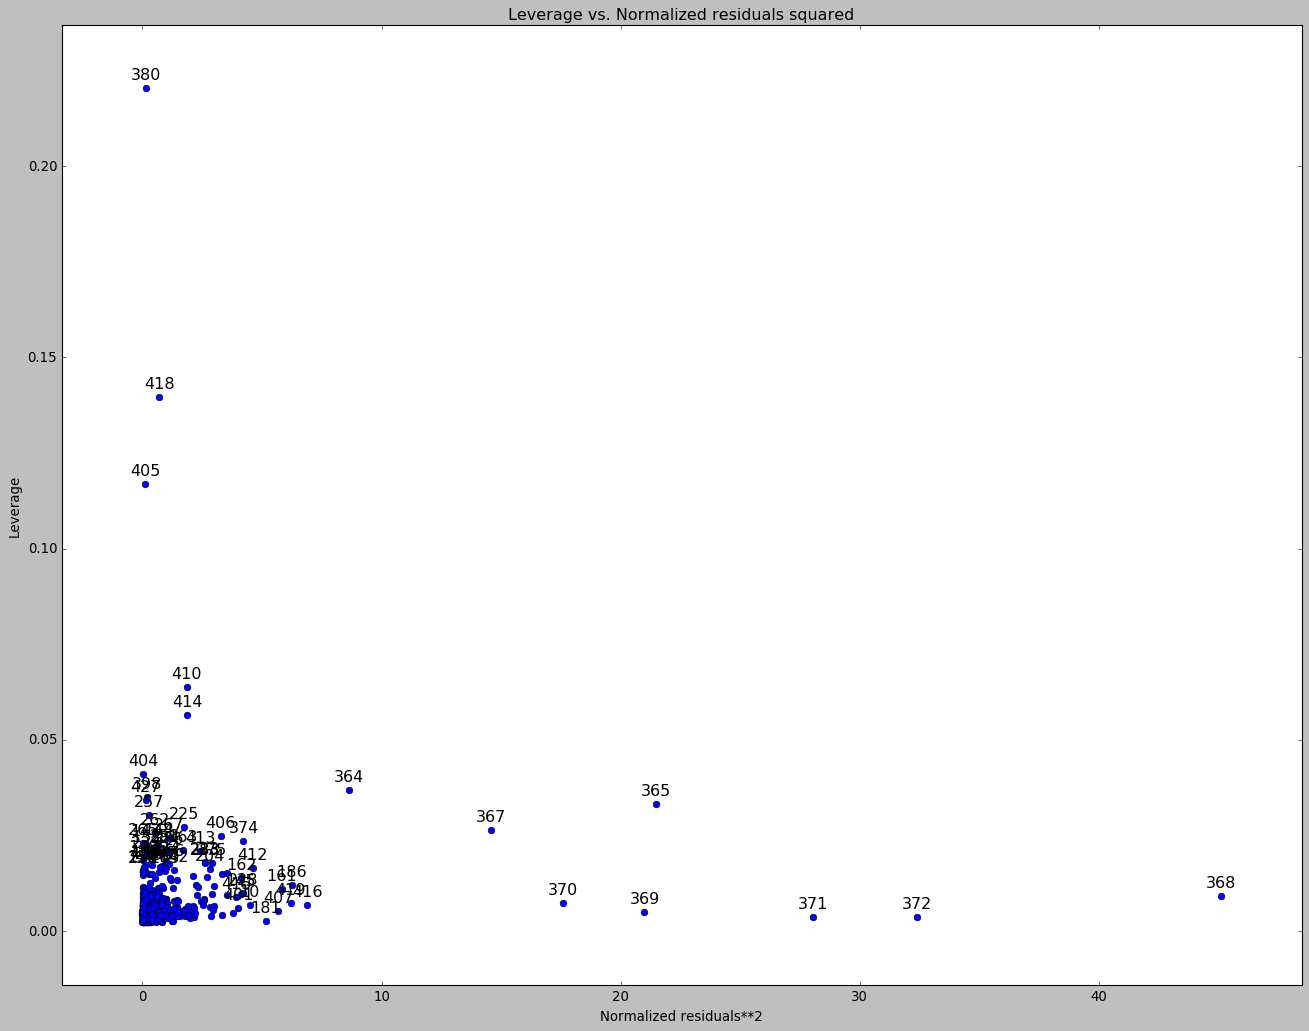

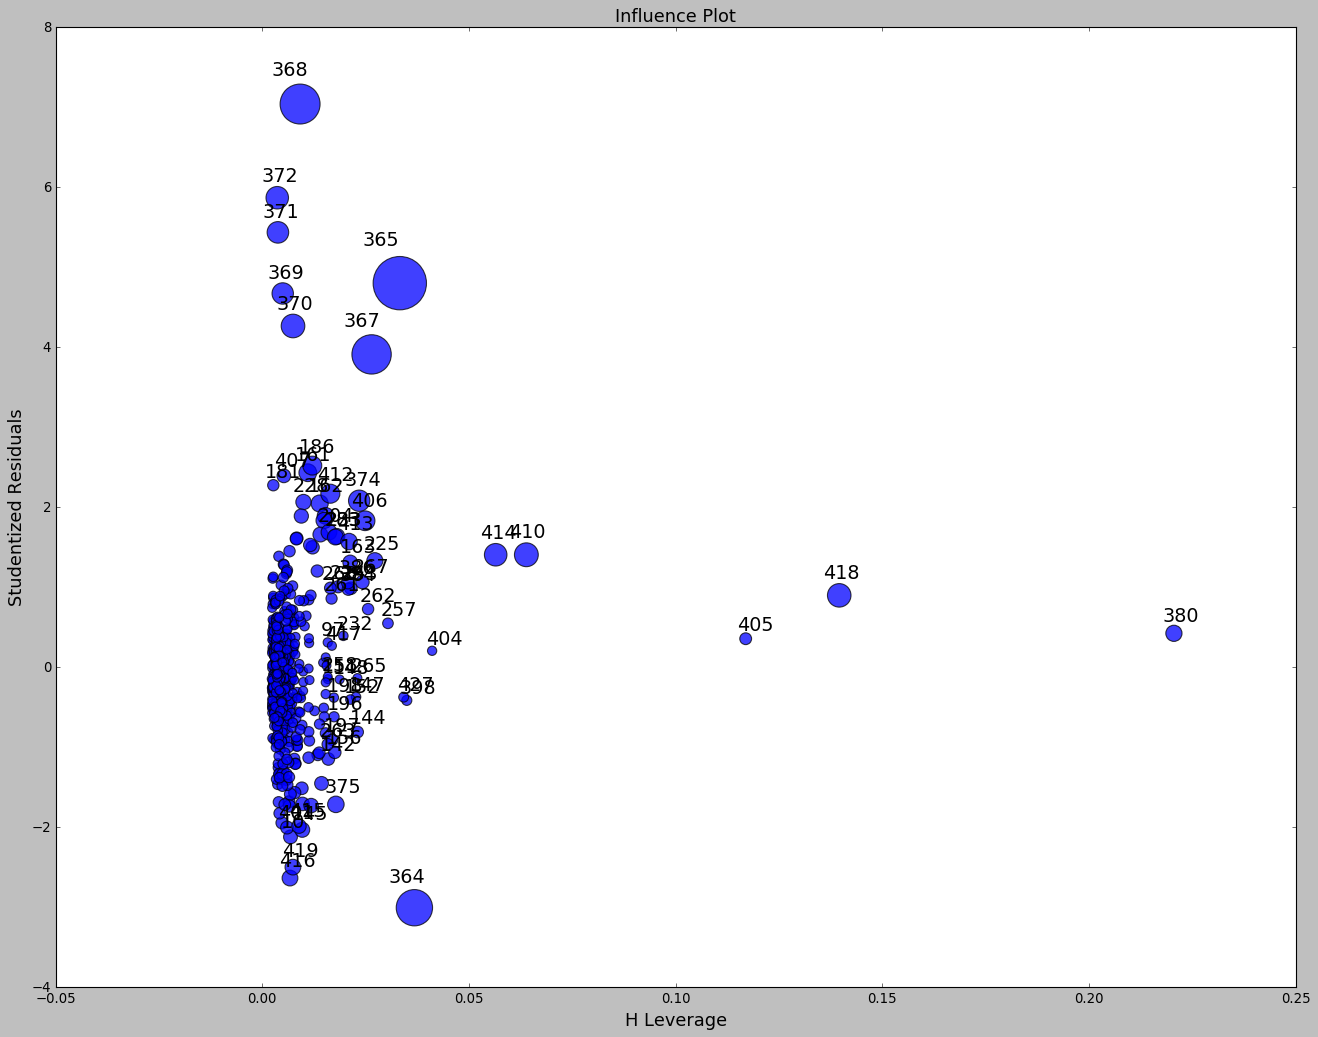

In [458]:
# construct a leverage plot
rcParams['figure.figsize'] = 20,15
from statsmodels.graphics.regressionplots import *
l=plot_leverage_resid2(m_3)
k=influence_plot(m_3)

In [459]:
#remove outliers
from random import random
import statsmodels.api as smapi
from statsmodels.formula.api import ols
import statsmodels.graphics as smgraphics
os = m_3.outlier_test(order=True)
lg = os.nlargest(7, 'student_resid')
outliers = list(lg.index)
outliers


[368, 372, 371, 365, 369, 370, 367]

In [460]:
# pick top 5 leverage points
model_cooks = m_3.get_influence().cooks_distance[0]

leverage_top_5 = list(np.flip(np.argsort(model_cooks), 0)[:5])

leverage_top_5

[365, 368, 367, 364, 410]

In [461]:
to_remove = set(outliers  + leverage_top_5)
to_remove = list(to_remove)

bos2 = bos.drop(bos.index[to_remove])

bos.count()-bos2.count()

CRIM         9
ZN           9
INDUS        9
CHAS         9
NOX          9
RM           9
AGE          9
DIS          9
RAD          9
TAX          9
PTRATIO      9
B            9
LSTAT        9
PRICE        9
FITTED       9
RESIDUALS    9
dtype: int64

In [462]:
# recreate the model
new_m = ols('PRICE ~ PTRATIO + CRIM + RM',bos2).fit()

In [463]:
print(m_3.summary())
print(new_m.summary())


                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     245.2
Date:                Thu, 16 May 2019   Prob (F-statistic):           6.15e-98
Time:                        23:35:20   Log-Likelihood:                -1612.0
No. Observations:                 506   AIC:                             3232.
Df Residuals:                     502   BIC:                             3249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.3707      4.034     -0.836      0.4

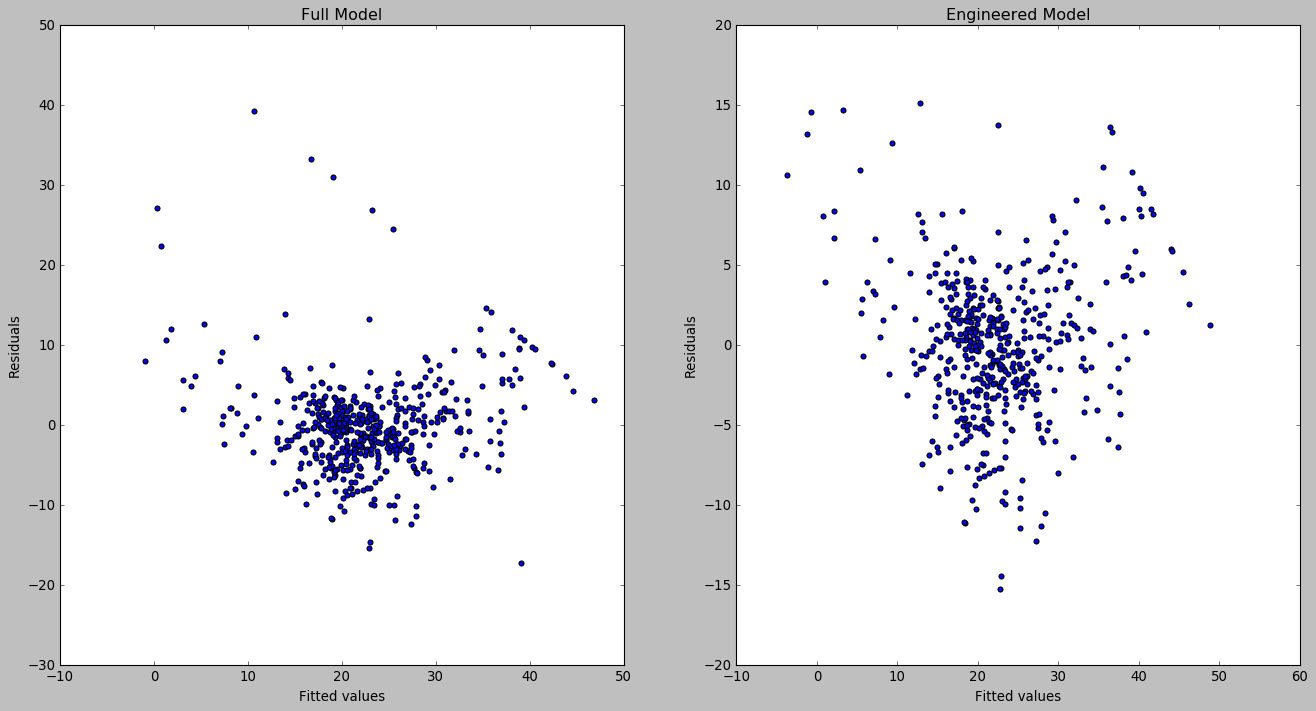

In [464]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(m_3.fittedvalues,m_3.resid)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")

_ = plt.title('Full Model')
plt.subplot(1, 2, 2)

plt.scatter(new_m.fittedvalues,new_m.resid)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
_ = plt.title('Engineered Model')

<Figure size 1200x800 with 0 Axes>

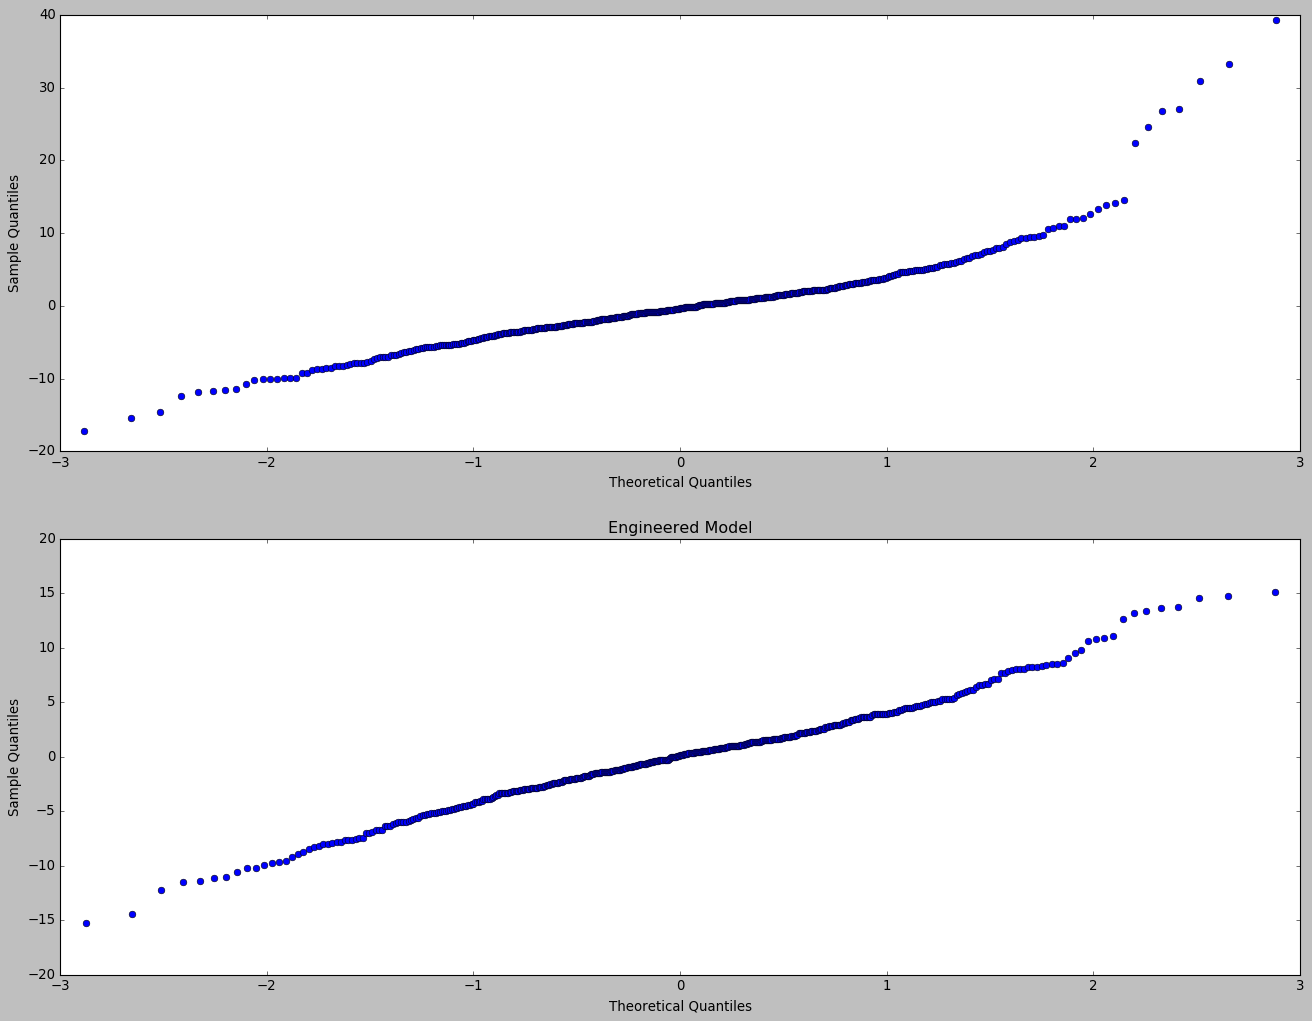

In [465]:
plt.figure(figsize=(15, 10))
fig, (ax, ax2) = plt.subplots(nrows=2)
sm.qqplot(m_3.resid,ax=ax)

_ = plt.title('Full Model')

sm.qqplot(new_m.resid,ax=ax2)

_ = plt.title('Engineered Model')


<div class="span5 alert alert-info">


    
1. Comparing the coefficients for the two summary results, we see that the high leverage points do influence the slope and intercept values of the model. Deleting an outlier that is not a high leverage point will have very little effect on the model. However, an outlier that is a high leverage point can significantly alter the model and should most likely be deleted.

1. By removing the outliers and highest leverage points, the model has improved considerably:

1. Coefficient of Determination R2 jumped from 0.594 to 0.729.

1. F-statistic The F-statistic nearly doubled from 245 to 443

1. AIC dropped from 3232 to 2935.

1. The correlation coefficient increased from 0.77 to 0.85.

</div>
